 ## Marcos Rigol 2010 PRE L=15 NN&imp L Santos Exercise 11

In [5]:
using QuantumOptics
using Plots
using Arpack
using ArnoldiMethod
using DelimitedFiles
using LaTeXStrings
using LinearAlgebra
using Statistics
pyplot()

Plots.PyPlotBackend()

### Set up the basis
We start by setting up the basis. We have `Nparticles` living on `Nsites`, and we use the QuantumOptics function `NLevelBasis()` to account for our sites. Each site is one level, which can be occupied by as many particles as we want (since we're dealing with bosons). For the basis size this is a little troublesome, since it leads to a large number of basis states. 

In [6]:
Nsites = 15                              # Actual number of physical sites is half this, we encode particle types at different sites
Nparticles = 5                     # To define the rotated state we initially need double the number of particles
a = NLevelBasis(Nsites)
a_mb = ManyBodyBasis(a, fermionstates(a, Nparticles))
Dim=size(a_mb.occupations)[1]; # Dimension of the Hilbert Space

The many-body basis is spanned by the different occupations on every site. We can inspect the occupation numbers:

In [8]:
a_mb.occupations;

### Set up the Hamiltonian

https://www.yu.edu/sites/default/files/legacy//uploadedFiles/Faculty/Lea_Ferreira_dos_Santos/Computer_Codes/Izmir2014_04(2).pdf
p.17-25

The initial Hamiltonian contains two terms, a tunneling term, and an on-site interaction term, respectively. If we express all energies in units of the tunneling rate $t$ the only free parameter is the on-site interaction $U$:
$$
 \mathcal{H}= 
 \sum_{i=1}^{L-1}\left[-t\left(f_i^{\dagger} f_{i+1}+h . c .\right)+V\left(n_i^f-\frac{1}{2}\right)\left(n_{i+1}^f-\frac{1}{2}\right)\right. 
 \left.\right] .
$$

This equation is exactly the same as XXZ model:
$$
\mathcal{H} =\sum_{j=1}^{L-1} J_x\left(\sigma_j^x \sigma_{j+1}^x+\sigma_j^y \sigma_{j+1}^y\right)+J_z \sigma_j^z \sigma_{j+1}^z
$$

The two matrices are the same when $t=J_x/2$, $V=J_z$ up to an identical matrix.

In this code, we have an impurity Hamiltonian in the middle of the chain so that the parity symmetry of the chain does not exist. Otherwise, we need to separate different Hilbert space sectors and consider the energy spacing of each own and average them, which is really frustrating. 

$$
H_{imp}=\epsilon \sigma_{[L/2]}^z = \epsilon n^f_{[L/2]}
$$

More importantly, this impurity provides a 'knob' to break the integrability. 

In [9]:
#NN_tunnel = [transition(a, i, mod(i,Nsites)+1) for i in 1 : Nsites]
NN_tunnel = [transition(a, i, i+1) for i in 1 : (Nsites-1)]
NN_tunnel = [dagger.(NN_tunnel); NN_tunnel]
total_NNtun = sum([manybodyoperator(a_mb, t) for t in NN_tunnel]);


In [37]:
NN_interaction = sum( [ (number(a_mb, i)- 0.5*identityoperator(a_mb)) * (number(a_mb, i+1) - 0.5*identityoperator(a_mb)) for i in 1:(Nsites-1) ] )

imp=number(a_mb, Int(floor(Nsites/2)));

imp_ed=number(a_mb, 1);

The next block defines several function:
1. integrable XXZ model Hamiltonian with no symmetry(open boundary), plus an impurity located on the edge or the center of the chain
2. The process of throwing away 10% of the eigenenergies on the edge and rescale the level spacing by 'unfolding process'.
3. The standard Poisson and Wigner-Dyson distribution.
4. A drawing function

In [52]:
H(ϵ,d) = -1*total_NNtun+0.96*NN_interaction+ϵ*imp+d*imp_ed

function Spec_fil(Energy_Spectrum)
    E_Spacing = [(Energy_Spectrum[i]-Energy_Spectrum[i-1]) for i in 2 : (Dim)];
    deleteat!(E_Spacing,1:1:Int(floor(0.05*Dim)));
    deleteat!(E_Spacing,length(E_Spacing)-Int(floor(0.05*Dim)):1:length(E_Spacing));  # Throw away the edge of spectrum
    F_Spacing=zeros(length(E_Spacing))
    for j in 1:10:(length(E_Spacing)-10)
        Avg_j=sum(E_Spacing[j:1:j+9])/10
        for i in 0:1:9
            F_Spacing[j+i]=E_Spacing[j+i]/Avg_j
        end
    end   # Unfold the spectrum by calculating the ratio between a specific space and a '10 sites' local spacing. 
    return F_Spacing
end
Poisson(x)=exp.(-x)
WDdist(x)=pi/2*x*exp.(-pi/4*x.^2);

function draw(Energy_Spectrum)
    histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
    plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
    plot!(Poisson,label="Poisson prediction",color=:red)
    xlims!(0, 5.0)
    ylims!(0, 1.2)
    title!("")
    xlabel!("s")
    ylabel!("P(s)")
end

draw (generic function with 1 method)

The next few blocks shows two things: 
1. As the strength of the impurity in the middle grows, the spectrum shifts from Poisson to Wigner-Dyson. But if impurity is too strong, the model becomes two irrelevant integrable chain. 
2. An impurity on the boundary of the chain does not introduce chaos to the system.

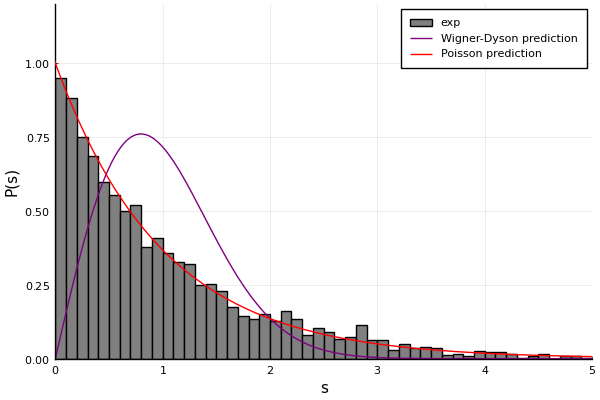

In [53]:
Energy_Spectrum=eigenstates(dense(H(0,0)))[1];
draw(Energy_Spectrum)

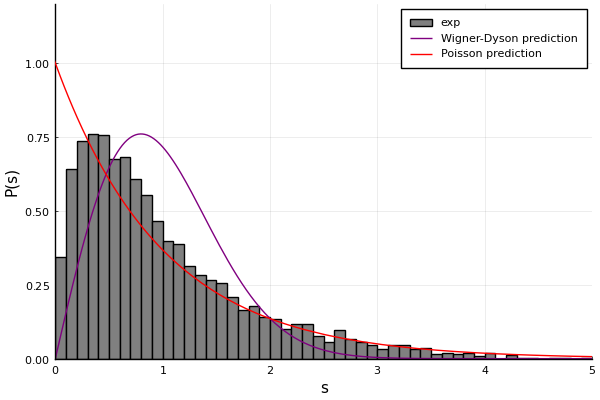

In [54]:
Energy_Spectrum=eigenstates(dense(H(0.1,0)))[1];
draw(Energy_Spectrum)

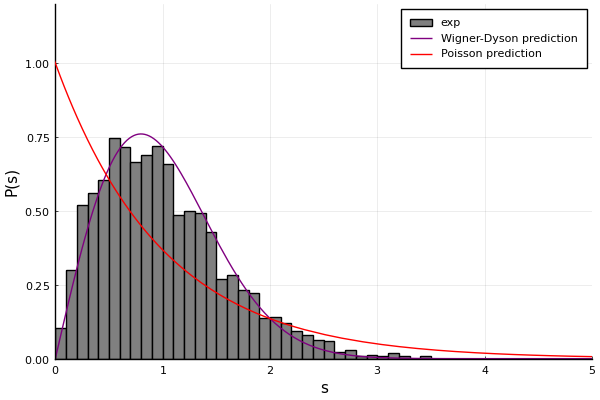

In [55]:
Energy_Spectrum=eigenstates(dense(H(0.5,0)))[1];
draw(Energy_Spectrum)

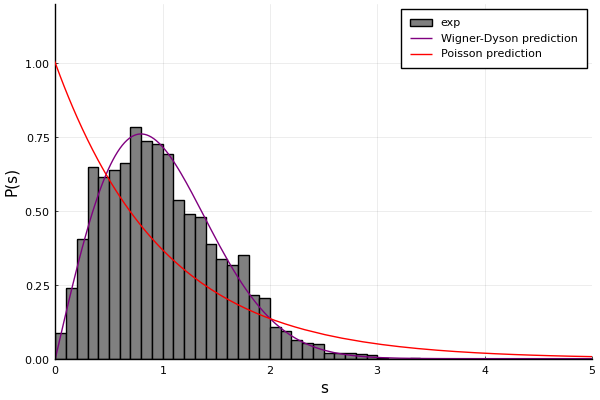

In [56]:
Energy_Spectrum=eigenstates(dense(H(2,0)))[1];
draw(Energy_Spectrum)

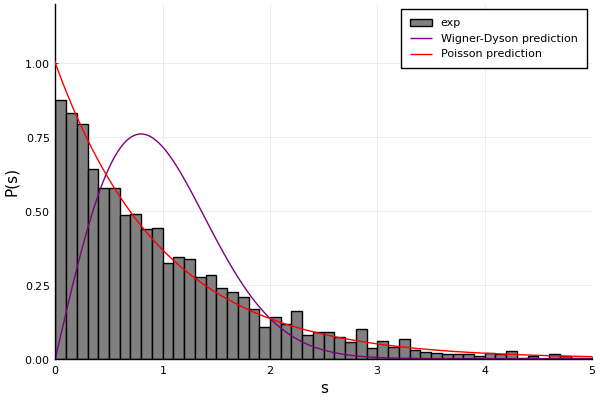

In [59]:
Energy_Spectrum=eigenstates(dense(H(0,2)))[1];
draw(Energy_Spectrum)

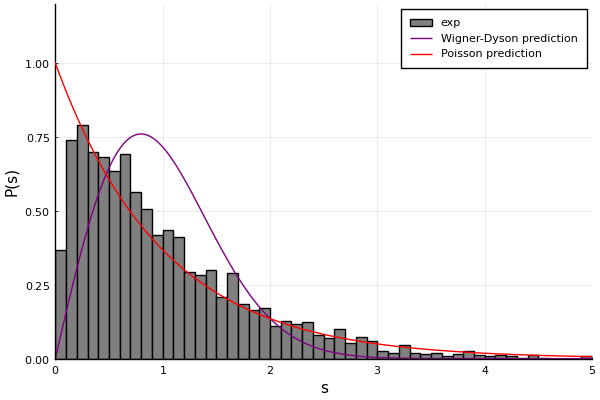

In [57]:
Energy_Spectrum=eigenstates(dense(H(10,0)))[1];
draw(Energy_Spectrum)

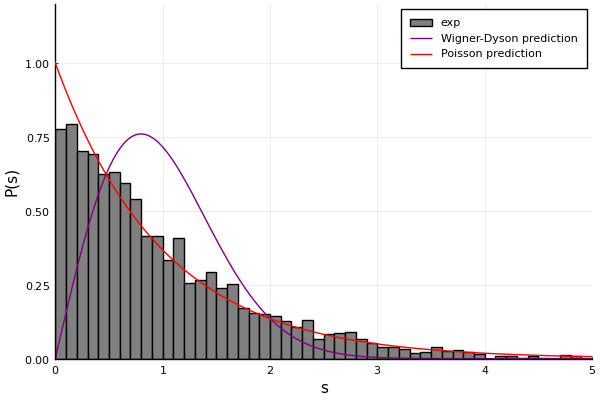

In [58]:
Energy_Spectrum=eigenstates(dense(H(50,0)))[1];
draw(Energy_Spectrum)